# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
#!export PYTHONPATH=/Users/clementcharles/Documents/Test_2/QFT_Dev/lattice_qft:${PYTHONPATH}
import math
import matplotlib.pyplot as plt
import time
import os
os.getcwd() 
import sys
#sys.path.append("./lattice_qft")
import scipy

from lattice_qft.core.arithmetic_pkg.shear import *
import lattice_qft.core.arithmetic_pkg.series
import lattice_qft.core.arithmetic_pkg.testing_utilities
from qiskit import *

import numpy as np
from numpy.linalg import cholesky, inv
import gmpy2
import matplotlib

#import sys
#sys.path.append('../harmonic_oscillator/')
#sys.path.append('../state_prep_folder/')

import lattice_qft.core.lattice as lattice_cf
#from harmonic_oscillator import settings
from lattice_qft.Scalar_Field_Theory.stateprep_1D import gaussian_wavefunction, analytic_gaussian_wavefunction, f

simulator = Aer.get_backend('unitary_simulator')
simulator_state = Aer.get_backend('statevector_simulator')

good


# 1D Gaussian State Prep, gate counts

## Gate counting functions

In [3]:
import matplotlib
'''
    j= iteration
    r= # fractional qubits for arithmetic
    b= # total qubits for arithmetic, (b-r is number of integral qubits)
    d= degree of series approximations, e.g. d=2 is the series a0 + a1(mu')^2 + a2(mu')^4
'''

def large_sigma_alpha_count(j, d, r):
    if j == 1:
        return 11*d*r**2 + 10*d*r - 3*r**2 + 49*r - 27*d + 94
    elif j == 2:
        return 11*d*r**2 + 10*d*r - 3*r**2 + 71*r - 27*d + 196
    else: # j >= 3
        return 11*d*r**2 + 10*d*r - 3*r**2 + 27*r - 27*d - 73 + 22*j*r + 11*j**2 + 111*j


def int_sigma_alpha_count(j, d, r, b):
    '''
    Count the number of gates to compute alpha.

    Precons:
        j  = 1..k
        r >= j + 1
        b >  r + 1 (b= r+2 minimum, which is a ones place and a sign)
    '''
    total= d * (22*b*(r-2) - 11*r**2 + 10*r + 61) + 11*b**2 + 22*r*(b-r) + 15*r - 21*b + 42 + 12*j
    
    # Add the CCM gates
    total+= 4*b*(d+1)
    
    if j == 1:
        total+= 38
    elif j == 2:
        total+= 158
    else: # j >= 3
        total+= 22*j**2 + 95*j - 123
    
    if d > 1:
        total+= 44*b*r - 22*r**2 - 120*b + 20*r + 122 + 8*b
        
    return total


def small_sigma_alpha_count():
    return 2

## Plot 1D prep. gate count, for several arbitrary specified σ. This code is also more efficient than the previous cell (although more lines)

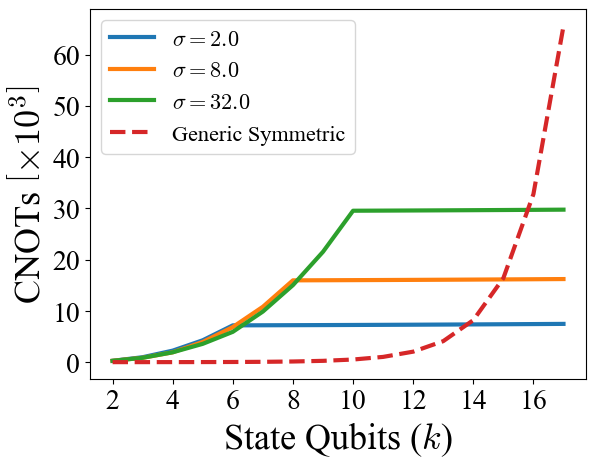

In [4]:
# Plot some arbitrary values of sigma
plt.rcParams['mathtext.fontset'] = 'cm'

kMax= 18 # number of qubits per lattice site.
d= 2
sigma0_list= [2, 8, 32]
countsArray_list= []

kArray= np.arange(2, kMax)

transition= {} # dictionary that stores where sigma transitions between regimes.

for sigma0 in sigma0_list:
    countsArray= np.zeros(kMax-2, dtype=int)

    for k in range(2, kMax):
        # j = k - 1
        r= k
        b= r + 1
    
        if k == 2:
            sigma= sigma0/2.
    
            if sigma > 0.65:
                countsArray[k-2]= large_sigma_alpha_count(k-1, d, r)
                
            elif sigma > 0.05:
                countsArray[k-2]= int_sigma_alpha_count(k-1, d, r, b)
            
                if '0.65' not in transition:
                    transition['0.65']= k

            else:
                countsArray[k-2]= 2
            
                if '0.05' not in transition:
                    transition['0.05']= k

        else:
            sigma/= 2.
            countsArray[k-2]= countsArray[k-3]
        
            if sigma > 0.65:
                countsArray[k-2]+= large_sigma_alpha_count(k-1, d, r)
                
            elif sigma > 0.05:
                countsArray[k-2]+= int_sigma_alpha_count(k-1, d, r, b)
            
                if '0.65' not in transition:
                    transition['0.65']= k

            else:
                countsArray[k-2]+= 2
            
                if '0.05' not in transition:
                    transition['0.05']= k
        
        countsArray[k-2]+= 2 * r
        #print('Counts= %d, k= %d, sigma= %.3f' %(countsArray[k-2], k, sigma0))
  
    countsArray_list.append(countsArray)

fig, ax= plt.subplots()
ax.yaxis.get_offset_text().set_font('times new roman')
ax.yaxis.get_offset_text().set_fontsize(20)

for j in range(len(sigma0_list)):
    plt.plot(kArray, countsArray_list[j]/1000, label='$\sigma=%.1f$' %(sigma0_list[j]), linewidth=3)

#plt.plot(kArray, 2**(kArray - 1.), label='Generic Symmetric', linewidth=3, linestyle='--')
plt.plot(kArray, (2**(kArray - 1.))/1000, label='Generic Symmetric', linewidth=3, linestyle='--')

#plt.title('1D Gaussian State Prep. Gate Count')
plt.xlabel('State Qubits ($k$)', fontname='times new roman', size=26)
plt.ylabel(r'CNOTs $\left[\times 10^3\right]$', fontname='times new roman', size=26)

plt.xticks(fontsize=20, fontname= 'times new roman')
plt.yticks(fontsize=20, fontname= 'times new roman')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,3))

plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 16))

#plt.savefig('1DPrep_CNOTs_fixedsigma_k<=%d.pdf' %(kMax), bbox_inches='tight')

## Plot 1D prep. gate count, now with σ the optimal function of the number of qubits (see eq. 11 in Wilson Lines paper).

## Note that all polynomial circuits are evaluated at degree d (4th line of the cell below)

Counts= 318, k= 2, sigma= 0.282
Counts= 1023, k= 3, sigma= 0.199
Counts= 2307, k= 4, sigma= 0.141
Counts= 4267, k= 5, sigma= 0.100
Counts= 7177, k= 6, sigma= 0.071
Counts= 7080, k= 7, sigma= 0.050
Counts= 11036, k= 8, sigma= 0.035
Counts= 10841, k= 9, sigma= 0.025
Counts= 15997, k= 10, sigma= 0.018
Counts= 15654, k= 11, sigma= 0.012
Counts= 22164, k= 12, sigma= 0.009
Counts= 21623, k= 13, sigma= 0.006
Counts= 29641, k= 14, sigma= 0.004
Counts= 28852, k= 15, sigma= 0.003
Counts= 38532, k= 16, sigma= 0.002
Counts= 37445, k= 17, sigma= 0.002
Counts= 48941, k= 18, sigma= 0.001


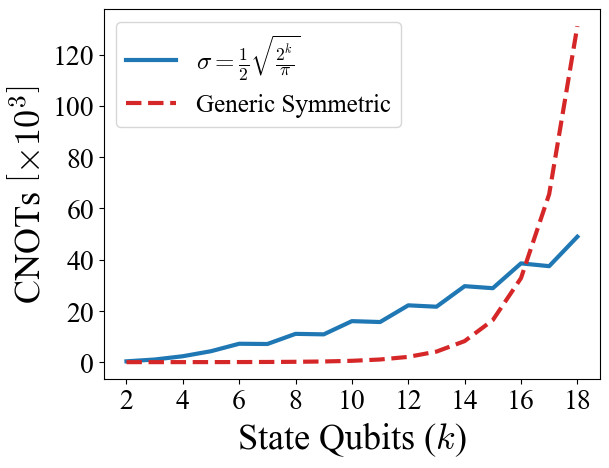

In [5]:
# Plot sigma, as a function of k
plt.rcParams['mathtext.fontset'] = 'cm'

kMax= 19 # number of qubits per lattice site.
d= 2

kArray= np.arange(2, kMax)
countsArray= np.zeros(kMax-2, dtype=int)

transition= {} # dictionary that stores where sigma transitions between regimes.

for k in range(2, kMax):
    sigma= 0.5 * np.sqrt(2**k / np.pi)
    counts= 0
    for j in range(1, k):
        r= j + 1     # a minimal assumption
        b= r + 1
        sigma/= 2.
    
        if sigma > 0.65:
            counts+= large_sigma_alpha_count(j, d, r)
                
        elif sigma > 0.05:
            counts+= int_sigma_alpha_count(j, d, r, b)
            
            if '0.65' not in transition:
                transition['0.65']= j

        else:
            counts+= 2
            
            if '0.05' not in transition:
                transition['0.05']= j
    
        counts+= 2 * r # rotating alpha
    countsArray[k-2]= counts
    
    print('Counts= %d, k= %d, sigma= %.3f' %(counts, k, sigma))

fig, ax= plt.subplots()
ax.yaxis.get_offset_text().set_font('times new roman')
ax.yaxis.get_offset_text().set_fontsize(20)

plt.plot(kArray, countsArray/1000, label=r'$\sigma=\frac{1}{2}\sqrt{\frac{2^k}{\pi}}$', linewidth=3)
#plt.plot(kArray, 2**(kArray - 1.) + kArray - 3, label='Generic Symmetric', linewidth=3, color='C3', linestyle='--')
plt.plot(kArray, (2**(kArray - 1.) + kArray - 3)/1000, label='Generic Symmetric', linewidth=3, color='C3', linestyle='--')

#plt.title('1D Gaussian State Prep. Gate Count')
plt.xlabel('State Qubits ($k$)', fontname='times new roman', size=26)
plt.ylabel(r'CNOTs $\left[\times 10^3\right]$', fontname='times new roman', size=26)

plt.xticks(fontsize=20, fontname= 'times new roman')
plt.yticks(fontsize=20, fontname= 'times new roman')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.yscale('log')

plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 18))

#plt.savefig('1DPrep_CNOTs_scalingsigma_k<=%d.pdf' %(kMax), bbox_inches='tight')
#plt.savefig('1D_CNOTs_k<=%d.png' %(kMax))

# Plot fidelity vs. number of alpha qubits

In [7]:
from lattice_qft.Scalar_Field_Theory.stateprep_1D import *
import matplotlib

#Load in the different backends
simulator = Aer.get_backend('unitary_simulator')
simulator_state = Aer.get_backend('statevector_simulator')

In [34]:
sigma= 1.
mu= -0.5

bMax= 10
kList= [2, 4, 6, 8]

fidels= np.zeros((len(kList), bMax - 2))

for b in range(2, bMax):
    for k in range(len(kList)):
        print(b, k)
        print('simple circuit')
        qc1= construct_circuit_simple(kList[k], sigma, mu, verbose=False)
        result1 = execute(qc1, simulator_state).result()
        sv1= result1.get_statevector().data[np.where((result1.get_statevector().data) > 1e-30)]
        
        print('approx circuit')
        qc1= construct_circuit(kList[k], b, sigma, mu)
        result2 = execute(qc1, simulator_state).result()
        sv2_nonzero= result2.get_statevector().data[np.where((result2.get_statevector().data) > 1e-30)]
        
        
        fidels[k][b-2]= qiskit.quantum_info.state_fidelity(sv1, sv2_nonzero)
        
print("Done.")

2 0
simple circuit
approx circuit
2 1
simple circuit
approx circuit


ValueError: shapes (8,) and (16,) not aligned: 8 (dim 0) != 16 (dim 0)

## Plot with line labels

NameError: name 'kList' is not defined

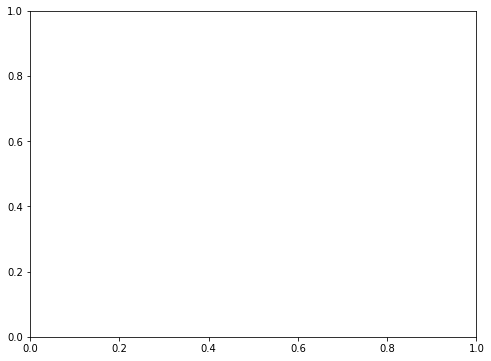

In [6]:
fig, ax= plt.subplots(figsize=(8,6))
ax.yaxis.get_offset_text().set_font('times new roman')
ax.yaxis.get_offset_text().set_fontsize(24)
ax.xaxis.get_offset_text().set_font('times new roman')
ax.xaxis.get_offset_text().set_fontsize(24)
      
for k in range(len(kList)):
    plt.plot(np.arange(2, bMax-1), np.log2(1-fidels[k][:-1]), label= r'$k=%d$' %(kList[k]), linewidth= 3)


#plt.title('1D Gaussian State Prep. Gate Count')
plt.xlabel(r'$\alpha$ register size $(b)$', fontname='times new roman', size=26)
plt.ylabel(r'$\log_2(1 - $Fidelity)', fontname='times new roman', size=26)

plt.xticks(np.arange(2, bMax), fontsize=20, fontname= 'times new roman')
plt.yticks(np.arange(-17.5, 2.5, 2.5), fontsize=20, fontname= 'times new roman')

plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 17), loc=1)

#plt.savefig("logApproxAlpha_bMax=%d_kmax=%d_labels.pdf" %(bMax-1, kList[-1]), bbox_inches='tight')
#plt.savefig("logApproxAlpha_bMax=%d_kmax=%d_labels.png" %(bMax-1, kList[-1]), bbox_inches='tight')

# Shearing

## Plot Fidelities: Shearing vs. Default as a function of qubits per lattice sites.

### Generate Dictionaries containing fidelities, nL fixed

In [35]:
from lattice_qft.Scalar_Field_Theory.classical import *

2
3
[0.95882198 0.9639232 ]
[0.9586092  0.96031735]


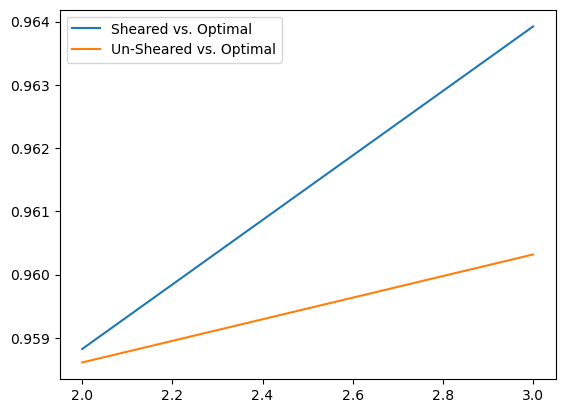

In [36]:
# Generate Fidelities for Plotting, for different nQ

dx = 1
nL= 3
nQmax= 4

fidels1= np.zeros(nQmax-2)
fidels2= np.zeros(nQmax-2)

label= np.arange(2, nQmax)

for n in range(2, nQmax):
    print(n)
    lattice2= Lattice(nL, n, dx, 1)

    ground= createEigenstate([0]*nL, lattice2)
    #groundX= createKWground_ext(lattice2, ool_keep=True, decompose_shear=False, binary_approx=True, testmode=False, twosite=False, new=True)
    groundX= createKWground(lattice2)
    groundNS= createKWstate([0]*nL, lattice2)
    
    fidels1[n-2]= qiskit.quantum_info.state_fidelity(ground, groundX)
    fidels2[n-2]= qiskit.quantum_info.state_fidelity(ground, groundNS)
    

plt.plot(label, fidels1, label= 'Sheared vs. Optimal')
plt.plot(label, fidels2, label= 'Un-Sheared vs. Optimal')

plt.legend()

#filename= 'fidels_nL=%d_nQ<=%d' %(nL, nQmax-1)
#np.savez(filename, sheared=fidels1, unsheared=fidels2)

print(fidels1)
print(fidels2)

### Generate Dictionaries containing fidelities, nQ fixed

In [37]:
# Generate Fidelities for Plotting, for different nQ

dx = 1
nLmax= 5
nQ= 5

fidels1= np.zeros(nLmax-2)
fidels2= np.zeros(nLmax-2)

label= np.arange(2, nLmax)

for nL in range(2, nLmax):
    print(nL)
    lattice2= Lattice(nL, nQ, dx, 1)
    ground= createGround(lattice2, twosite=False)
    groundX= createKWground(lattice2, ool_keep=True, decompose_shear=False, binary_approx=True, testmode=False, twosite=False, new=False)
    groundNS= createKWground_NoShear(lattice2)
    
    fidels1[nL-2]= qiskit.quantum_info.state_fidelity(ground, groundX)
    fidels2[nL-2]= qiskit.quantum_info.state_fidelity(ground, groundNS)
    

plt.plot(label, fidels1, label= 'Sheared vs. Optimal')
plt.plot(label, fidels2, label= 'Un-Sheared vs. Optimal')

plt.legend()

np.savez(filename, sheared=fidels1, unsheared=fidels2)

2


NameError: name 'createGround' is not defined

## Plot several fixed N values together, while varying k

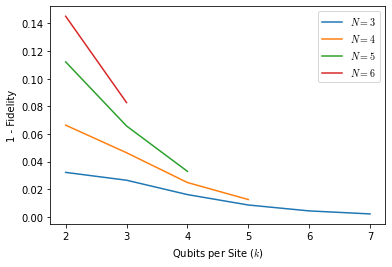

In [9]:
f3= np.load('fidels_nL=3_nQ<=7.npz')
f4= np.load('fidels_nL=4_nQ<=5.npz')
f5= np.load('fidels_nL=5_nQ<=4.npz')
f6= np.load('fidels_nL=6_nQ<=3.npz')

plt.plot(np.arange(2, 8), 1-f3['sheared'], label=r'$N= 3$')
plt.plot(np.arange(2, 6), 1-f4['sheared'], label=r'$N= 4$')
plt.plot(np.arange(2, 5), 1-f5['sheared'], label=r'$N= 5$')
plt.plot(np.arange(2, 4), 1-f6['sheared'], label=r'$N= 6$')

plt.xlabel('Qubits per Site ($k$)')
plt.ylabel('1 - Fidelity')

plt.legend()

## Plot several fixed values of k together, while varying N

In [38]:
d3= np.load('fidels_logNprecision_nQ=2_nL<=8.npz')
d4= np.load('fidels_logNprecision_nQ=3_nL<=6.npz')
d5= np.load('fidels_logNprecision_nQ=4_nL<=5.npz')
d6= np.load('fidels_logNprecision_nQ=5_nL<=4.npz')

plt.plot(np.arange(2, 9), 1-d3['sheared'], label=r'$k= 2$')
plt.plot(np.arange(2, 7), 1-d4['sheared'], label=r'$k= 3$')
plt.plot(np.arange(2, 6), 1-d5['sheared'], label=r'$k= 4$')
plt.plot(np.arange(2, 5), 1-d6['sheared'], label=r'$k= 5$')

plt.xlabel('Lattice Sites ($N$)')
plt.ylabel('1 - Fidelity')

plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'fidels_logNprecision_nQ=2_nL<=8.npz'

## Fidelity fitting

### Fidelity scaling function

In [39]:
def func(Nk, a, b):
    # Nk is a tuple
    N, k= Nk
    return 1 - (np.exp(8*np.pi*N*b / 2**k) * (1 - scipy.special.erf(2*np.sqrt(np.pi)*a / 2**(k/2)))**(2*N))

def fitfunc(Nk, a, b):
    # High sigma approximation
    N, k= Nk
    return 1 - np.exp(-8*a*N / 2**(k/2)) * (1 + (2*b - 4*a**2/np.pi)*(N*np.pi/2**(k-2)))

### Plotting params for figs. 7, 8

In [40]:
linewidth= 5
label_size= 58
ticks_size= 46
legend_size= 30
fig_size= [12,9]

### Fit and plot, fixed N

In [41]:
plt.rcParams['mathtext.fontset'] = 'cm'

NArray= np.array([3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6])
kArray= np.array([2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 2, 3, 4, 2, 3])

print(f3)

g3= 1 - f3['sheared']
g4= 1 - f4['sheared']
g5= 1 - f5['sheared']
g6= 1 - f6['sheared']

dataArray= np.array([g3[0], g3[1], g3[2], g3[3], g3[4], g3[5], 
                g4[0], g4[1], g4[2], g4[3], 
                g5[0], g5[1], g5[2], 
                g6[0], g6[1]])


params, covars= scipy.optimize.curve_fit(func, (NArray, kArray), dataArray)



plt.figure(figsize= fig_size)
plt.rcParams['mathtext.fontset'] = 'cm'

kAx= np.arange(2, 10, 0.1)
nAx= np.ones(kAx.size)

plt.plot(kAx, func((3*nAx, kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)
plt.plot(kAx, func((4*nAx, kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)
plt.plot(kAx, func((5*nAx, kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)
plt.plot(kAx, func((6*nAx, kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)

plt.scatter(np.arange(2,8), g3, s= 100, label=r'$N= 3$')
plt.scatter(np.arange(2,6), g4, s= 100, label=r'$N= 4$')
plt.scatter(np.arange(2,5), g5, s= 100, label=r'$N= 5$')
plt.scatter(np.arange(2,4), g6, s= 100, label=r'$N= 6$')

plt.xlabel('$k$', size= label_size, fontname='times new roman', labelpad= 20)
plt.ylabel('$1-F$', size= label_size, fontname='times new roman', labelpad= 20)

plt.xticks(fontsize= ticks_size, fontname= 'times new roman')
plt.yticks(np.arange(0, 0.17, 0.04), fontsize= ticks_size, fontname= 'times new roman')
plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= legend_size + 1))

plt.tight_layout()
#plt.savefig('shearing_fidelities_k.pdf', bbox_inches='tight')

print('(a, b)= ' + str(params))
perr = np.sqrt(np.diag(covars))
print('1σ error= ' + str(perr))

NameError: name 'f3' is not defined

In [42]:
plt.figure(figsize= fig_size)
plt.rcParams['mathtext.fontset'] = 'cm'

dk2= np.array([g3[0], g4[0], g5[0], g6[0]])
dk3= np.array([g3[1], g4[1], g5[1], g6[1]])
dk4= np.array([g3[2], g4[2], g5[2]])
dk5= np.array([g3[3], g4[3]])
dk6= np.array([g3[4]])
dk7= np.array([g3[5]])

nAx= np.arange(2, 10, 0.1)
kAx= np.ones(nAx.size)

plt.plot(nAx, func((nAx, 2*kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)
plt.plot(nAx, func((nAx, 3*kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)
plt.plot(nAx, func((nAx, 4*kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)
plt.plot(nAx, func((nAx, 5*kAx), params[0], params[1]), linestyle= 'dotted', linewidth= linewidth-2)
#plt.plot(nAx, func((nAx, 6*kAx), params[0], params[1]), linestyle= 'dotted', linewidth= 1, label=r'$k= 6$')
#plt.plot(nAx, func((nAx, 7*kAx), params[0], params[1]), linestyle= 'dotted', linewidth= 1, label=r'$k= 7$')

plt.scatter(np.arange(2,6), dk2, s= 100, label=r'$k= 2$')
plt.scatter(np.arange(2,6), dk3, s= 100, label=r'$k= 3$')
plt.scatter(np.arange(2,5), dk4, s= 100, label=r'$k= 4$')
plt.scatter(np.arange(2,4), dk5, s= 100, label=r'$k= 5$')
#plt.scatter(np.arange(2,3), dk6, linewidths= 0.01)
#plt.scatter(np.arange(2,3), dk7, linewidths= 0.01)

plt.xlabel('$N$', size= label_size, fontname='times new roman', labelpad= 20)
plt.ylabel('$1-F$', size= label_size, fontname='times new roman', labelpad= 20)

plt.xticks(fontsize= ticks_size, fontname= 'times new roman')
plt.yticks(np.arange(0, 0.21, 0.04), fontsize= ticks_size, fontname= 'times new roman')
plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= legend_size + 1))

plt.tight_layout()
#plt.savefig('shearing_fidelities_N.pdf', bbox_inches='tight')

NameError: name 'g3' is not defined

<Figure size 1200x900 with 0 Axes>

## Plotting Gate Counts for Shearing

### Define CNOT count functions

In [15]:
def row_cnots(k, r, S, i):
    return (S - i - 1) * (8*k**2 + 16*r**2 + 16*k*r + 52*r + 22*k - 16)
    
def shear_cnots(k, r, S):
    return (S**2 - S)*(4*k**2 + 8*r**2 + 8*k*r + 26*r + 11*k - 8)

### Plot -- Klco/Savage 1D prep + shearing vs. Qiskit default prep -- Each plot shows the gate count as a function of lattice sites, for a particular number of qubits per site.

k(N)= [2. 2. 3. 3. 3. 3. 4. 4. 4. 4.]
k(N)= [6. 6. 7. 7. 8. 8. 8. 8. 9. 9.]
k(N)= [11. 12. 12. 13. 13. 13. 14. 14. 14. 15.]


([<matplotlib.axis.YTick at 0x7f9770bf38b0>,
 [Text(0, -50000000000000.0, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 50000000000000.0, '0.5'),
  Text(0, 100000000000000.0, '1.0'),
  Text(0, 150000000000000.0, '1.5'),
  Text(0, 200000000000000.0, '2.0'),
  Text(0, 250000000000000.0, '2.5'),
  Text(0, 300000000000000.0, '3.0')])

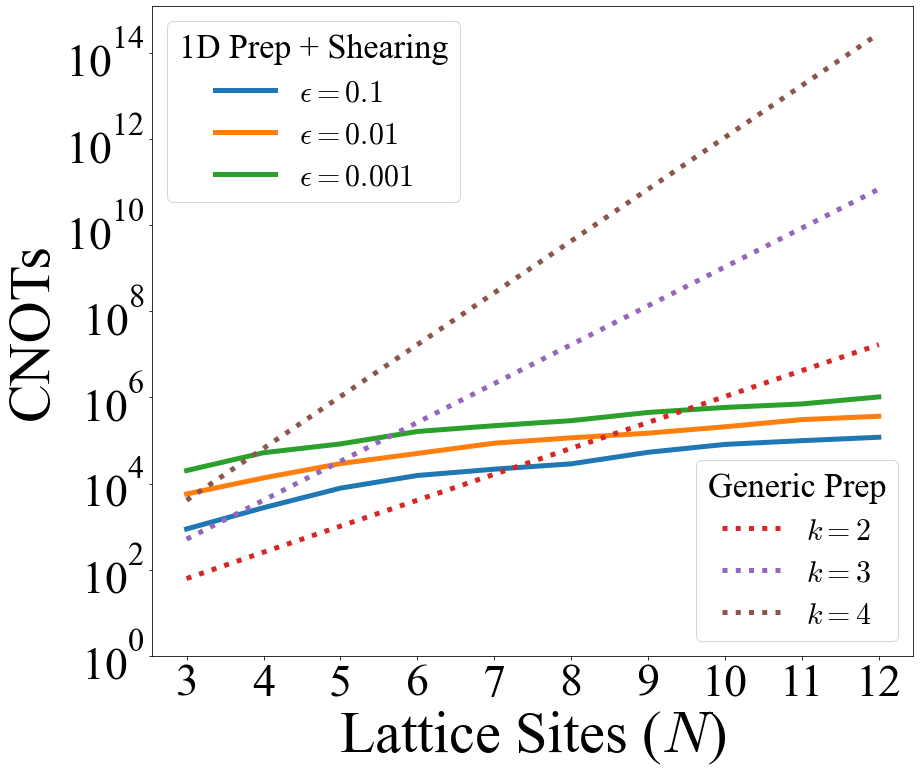

In [16]:
from matplotlib.lines import Line2D

plt.rcParams['mathtext.fontset'] = 'cm'

nLmax= 13


NArray= np.arange(3, nLmax, 1)
kArray= np.ones(NArray.size)

plt.figure(figsize= [12,11])

line_list= []
for eps in [0.1, 0.01, 0.001]:
    for N in NArray:    
        k= 2
        funcval= func((N, k), params[0], params[1])

        while funcval > eps:
            k+= 1
            if N*k > 12*1e5:
                funcval= fitfunc((N, k), params[0], params[1])
            else:
                funcval= func((N, k), params[0], params[1])


        kArray[N-3]= k
    print('k(N)= ' + str(kArray))

    rArray= kArray - 1 + np.ceil(np.log2(NArray-1))
    rArray= rArray.astype(int)

    CNOTs= shear_cnots(kArray, rArray, NArray)

    # Just Shearing
    #plt.plot(NArray, np.log2(CNOTs), label='Shearing')

    # Klco/Savage 1D prep: 2^(n-1) + n - 3 + delta(n)
    # Shearing plus 1D prep: S k-qubit Gaussians
    total= CNOTs + NArray*(2**(kArray-1) + kArray - 3)

    line, = plt.plot(NArray, total, linewidth=linewidth)
    line_list.append(line)
    # Shende: 2^(n+1) - 2n CNOTs
    #plt.plot(NArray, np.log2(2**(k*NArray + 1) - (2*k*NArray)), label='Default State Prep')
    #plt.plot(NArray, np.log2(2**(kArray*NArray) - 2), label='Default State Prep', linewidth=3)


line1, = plt.plot(NArray, 2**(2*NArray) - 2, linewidth=linewidth, linestyle='dotted') # k= 2
line2, = plt.plot(NArray, 2**(3*NArray) - 2, linewidth=linewidth, linestyle='dotted') # k= 3
line3, = plt.plot(NArray, 2**(4*NArray) - 2, linewidth=linewidth, linestyle='dotted') # k= 4

plt.xlabel('Lattice Sites ($N$)', fontname='times new roman', size= label_size)
plt.ylabel('CNOTs', fontname='times new roman', size= label_size)
    
#plt.title('Fidelity threshold= %.3f' %(eps), fontname='times new roman', size=24)

leg= first_legend = plt.legend(line_list, [r'$\epsilon= 0.1$', r'$\epsilon= 0.01$', r'$\epsilon= 0.001$'], loc='upper left',
                               prop=matplotlib.font_manager.FontProperties(family='times new roman', size= legend_size))
leg.set_title('1D Prep + Shearing', prop= matplotlib.font_manager.FontProperties(family='times new roman', 
                                                                            size= legend_size+4))

plt.gca().add_artist(first_legend)
leg= plt.legend([line1, line2, line3], ['$k= 2$', '$k= 3$', '$k= 4$'], loc='lower right',
                prop=matplotlib.font_manager.FontProperties(family='times new roman', size= legend_size))
leg.set_title('Generic Prep', prop= matplotlib.font_manager.FontProperties(family='times new roman', 
                                                                            size= legend_size+4))

plt.rcParams['legend.title_fontsize']= legend_size
#plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 24))
plt.xticks(np.arange(3, nLmax, 1), fontsize= ticks_size, fontname= 'times new roman')

plt.tight_layout()
plt.yscale('log')

plt.yticks(10**np.arange(0, 15, 2), fontsize= ticks_size, fontname= 'times new roman')

#plt.savefig('shearing_CNOT_comparison.pdf', bbox_inches='tight')
#plt.show()
#print(plt.rcParams)

### See how k(N) scales, roughly

In [17]:
for eps in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    for N in NArray:    
        k= 2
        funcval= func((N, k), params[0], params[1])

        while funcval > eps:
            k+= 1
            if N*k > 12*1e5:
                funcval= fitfunc((N, k), params[0], params[1])
            else:
                funcval= func((N, k), params[0], params[1])


        kArray[N-3]= k
    print('k(N)= ' + str(kArray))

k(N)= [2. 2. 3. 3. 3. 3. 4. 4. 4. 4.]
k(N)= [6. 6. 7. 7. 8. 8. 8. 8. 9. 9.]
k(N)= [11. 12. 12. 13. 13. 13. 14. 14. 14. 15.]
k(N)= [17. 18. 19. 19. 20. 20. 20. 21. 21. 21.]
k(N)= [17. 18. 19. 19. 20. 20. 20. 21. 21. 21.]
k(N)= [24. 25. 25. 26. 26. 27. 27. 27. 27. 28.]
k(N)= [30. 31. 32. 32. 33. 33. 34. 34. 34. 34.]
k(N)= [37. 38. 38. 39. 39. 40. 40. 40. 41. 41.]


k(N)= [2. 2. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4.]
Qubits= [11. 15. 24. 29. 32. 35. 49. 55. 59. 63. 67. 71.]
k(N)= [6. 6. 7. 7. 8. 8. 8. 8. 9. 9. 9. 9.]
Qubits= [ 31.  39.  52.  61.  77.  85.  93. 103. 124. 133. 142. 151.]
k(N)= [11. 12. 12. 13. 13. 13. 14. 14. 14. 15. 15. 15.]
Qubits= [ 56.  75.  87. 109. 122. 135. 159. 175. 189. 217. 232. 247.]


(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300')])

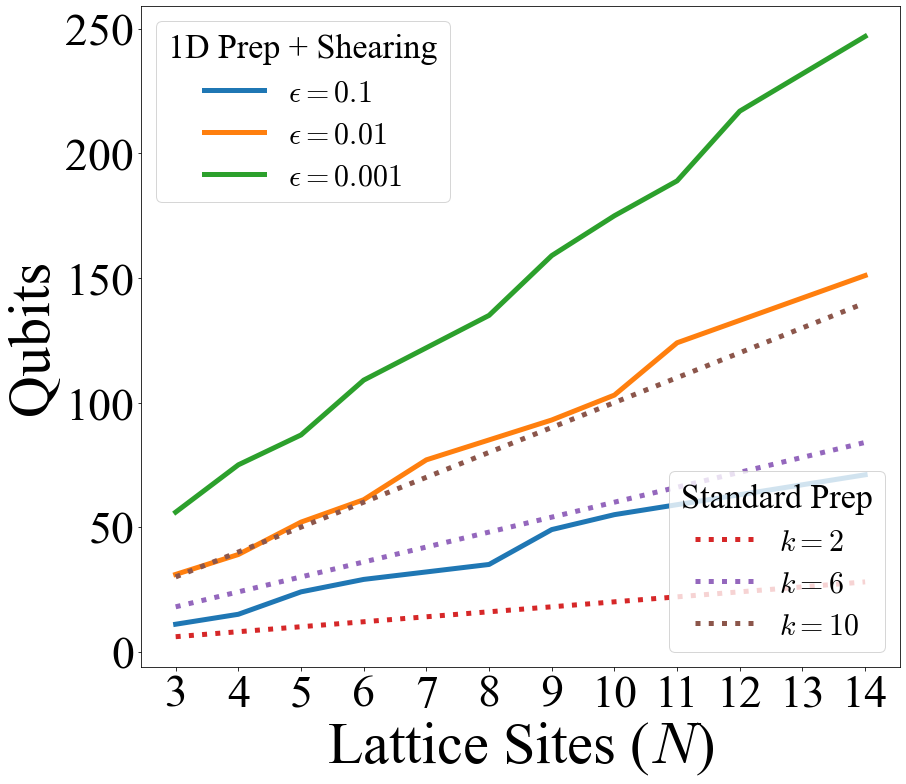

In [18]:
from matplotlib.lines import Line2D

plt.rcParams['mathtext.fontset'] = 'cm'

nLmax= 15


NArray= np.arange(3, nLmax, 1)
kArray= np.ones(NArray.size)

plt.figure(figsize= [12,11])

line_list= []
for eps in [0.1, 0.01, 0.001]:
    for N in NArray:    
        k= 2
        funcval= func((N, k), params[0], params[1])

        while funcval > eps:
            k+= 1
            if N*k > 12*1e5:
                funcval= fitfunc((N, k), params[0], params[1])
            else:
                funcval= func((N, k), params[0], params[1])


        kArray[N-3]= k

    rArray= kArray - 1 + np.ceil(np.log2(NArray-1))
    rArray= rArray.astype(int)

    qubits= (2*rArray + 1) + (kArray * NArray)

    print('k(N)= ' + str(kArray))
    print('Qubits= ' + str(qubits))

    line, = plt.plot(NArray, qubits, linewidth=linewidth)
    line_list.append(line)
    # Shende: 2^(n+1) - 2n CNOTs
    #plt.plot(NArray, np.log2(2**(k*NArray + 1) - (2*k*NArray)), label='Default State Prep')
    #plt.plot(NArray, np.log2(2**(kArray*NArray) - 2), label='Default State Prep', linewidth=3)


line1, = plt.plot(NArray, (2*NArray), linewidth=linewidth, linestyle='dotted') # k= 2
line2, = plt.plot(NArray, (6*NArray), linewidth=linewidth, linestyle='dotted') # k= 3
line3, = plt.plot(NArray, (10*NArray), linewidth=linewidth, linestyle='dotted') # k= 4

plt.xlabel('Lattice Sites ($N$)', fontname='times new roman', size= label_size)
plt.ylabel('Qubits', fontname='times new roman', size= label_size)
    
#plt.title('Fidelity threshold= %.3f' %(eps), fontname='times new roman', size=24)

leg= first_legend = plt.legend(line_list, [r'$\epsilon= 0.1$', r'$\epsilon= 0.01$', r'$\epsilon= 0.001$'], loc='upper left',
                               prop=matplotlib.font_manager.FontProperties(family='times new roman', size= legend_size))
leg.set_title('1D Prep + Shearing', prop= matplotlib.font_manager.FontProperties(family='times new roman', 
                                                                            size= legend_size+4))

plt.gca().add_artist(first_legend)
leg= plt.legend([line1, line2, line3], ['$k= 2$', '$k= 6$', '$k= 10$'], loc='lower right',
                prop=matplotlib.font_manager.FontProperties(family='times new roman', size= legend_size))
leg.set_title('Standard Prep', prop= matplotlib.font_manager.FontProperties(family='times new roman', 
                                                                            size= legend_size+4))

plt.rcParams['legend.title_fontsize']= legend_size
#plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 24))
plt.xticks(np.arange(3, nLmax, 1), fontsize= ticks_size, fontname= 'times new roman')

plt.tight_layout()
#plt.yscale('log')

plt.yticks(fontsize= ticks_size, fontname= 'times new roman')

#plt.savefig('shearing_qubit_comparison.pdf', bbox_inches='tight')
#plt.show()
#print(plt.rcParams)